In [1]:
import h5py
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sample from Train Data
It's necessary to take a sample here, because there is so much data. Even sampling just 50 individual time series, we end up with nearly 500 rows of data.  

In [39]:
def sample_from_index(hdf5_file, index_file, num_series=5):
    """
    Samples full time series from an HDF5 file using precomputed indices in an index CSV.

    Parameters:
        hdf5_file (str): Path to the main dataset HDF5 file.
        index_file (str): Path to the CSV index file storing time series indices.
        num_series (int): Number of full time series to sample.

    Returns:
        sampled_X (np.array): Sampled feature data.
        sampled_y (np.array): Corresponding labels.
    """
    index_df = pd.read_csv(index_file)

    # randomly sample num_series time series
    num_series = min(num_series, len(index_df))
    sampled_series = index_df.sample(num_series).sort_values(by=["start_idx"])

    sampled_rows = []
    for _, row in sampled_series.iterrows():
        sampled_rows.extend(range(row["start_idx"], row["stop_idx"] + 1))


    # load only the required rows
    with h5py.File(hdf5_file, "r") as infile:
        columns = [col.decode("utf-8") for col in infile.attrs["columns"]]
        sampled_X = infile["X"][sampled_rows]
        sampled_y = infile["y"][sampled_rows]

    print(f"Sampled {len(sampled_X)} rows covering {num_series} full time series.")
    return sampled_X, sampled_y, columns


In [74]:
# Read in our data

X, y, cols = sample_from_index("../../engine_train.h5", "../../engine_index.csv", num_series=100)

Sampled 885701 rows covering 100 full time series.


In [75]:
y = y.reshape((y.shape[0], 1))
df = pd.DataFrame(np.concatenate((X, y), axis=1), columns=cols+["RUL"])
df.head()

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL
0,6019.0,0.355824,44.120781,509.795929,577.807800,1328.385132,1600.943848,1151.262085,15.791724,12.813744,...,0.0,-0.001111,0.0,0.0,0.0,1.0,26.0,1.0,1.0,74.0
1,6019.0,0.355824,44.120781,509.795593,577.856812,1328.345581,1600.354980,1150.742432,15.793562,12.813710,...,0.0,-0.001111,0.0,0.0,0.0,1.0,26.0,1.0,1.0,74.0
2,6019.0,0.355761,44.120781,509.791473,577.845398,1328.347900,1600.488281,1150.869873,15.792788,12.813342,...,0.0,-0.001111,0.0,0.0,0.0,1.0,26.0,1.0,1.0,74.0
3,6019.0,0.356013,44.120781,509.808594,577.861389,1328.368408,1600.508667,1150.870728,15.794469,12.814879,...,0.0,-0.001111,0.0,0.0,0.0,1.0,26.0,1.0,1.0,74.0
4,6019.0,0.356076,44.120781,509.813416,577.867737,1328.374512,1600.489136,1150.848145,15.794990,12.815312,...,0.0,-0.001111,0.0,0.0,0.0,1.0,26.0,1.0,1.0,74.0


## Average Point of Engine Health Failure 

In [76]:
# Select relevant columns and drop duplicates to get unique combinations
unique_units_cycles_hs = df[['unit', 'cycle', 'hs']].drop_duplicates().reset_index(drop=True)
unique_units_cycles_hs = unique_units_cycles_hs.sort_values(by=['unit', 'cycle']).reset_index(drop=True)

# Display the unique combinations
pd.set_option('display.max_rows', 200)
display(unique_units_cycles_hs)

,unit,cycle,hs
0,1.0,22.0,1.0
1,1.0,26.0,1.0
2,1.0,27.0,1.0
3,1.0,28.0,1.0
4,1.0,35.0,0.0
5,1.0,62.0,0.0
6,1.0,68.0,0.0
7,2.0,8.0,1.0
8,2.0,15.0,1.0
9,2.0,16.0,1.0


In [78]:
# Initialize a list to store the cycle numbers where "hs" switches from 1 to 0
switch_cycle_numbers = []
df_sorted = df.sort_values(by=['unit', 'cycle']).reset_index(drop=True)

# Group by 'unit' to process each engine separately
for unit, group in df_sorted.groupby('unit'):
    # Find the index where "hs" switches from 1 to 0
    switch_index = group[(group['hs'].shift(1) == 1) & (group['hs'] == 0)].index
    
    # If there is a switch, get the corresponding cycle number
    if not switch_index.empty:
        first_switch_index = switch_index[0] 
        switch_cycle_number = group.loc[first_switch_index, 'cycle']
        cycle_before_switch = group.loc[first_switch_index - 1, 'cycle']  # Cycle number before the switch
        switch_cycle_numbers.append((cycle_before_switch + switch_cycle_number) / 2)

# Calculate the average cycle number where the switch occurs
if switch_cycle_numbers:
    average_cycle_number = sum(switch_cycle_numbers) / len(switch_cycle_numbers)
    print(f"Average cycle number where 'hs' switches from 1 to 0: {average_cycle_number:.2f}")
else:
    print("No switches found in the sample.")

print(switch_cycle_numbers)

Average cycle number where 'hs' switches from 1 to 0: 25.17
[31.5, 18.5, 26.0, 28.0, 12.0, 21.5, 25.5, 23.5, 40.0]


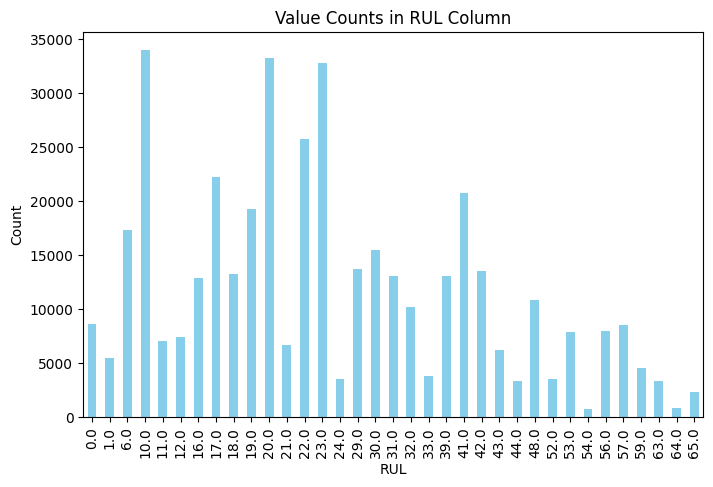

In [28]:
df_unhealthy = df[df['hs'] == 0]

# Count occurrences
value_counts = df_unhealthy['RUL'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.title('Value Counts in RUL Column')
plt.show()


In [22]:
# Create a list of columns 

feature_cols = [col for col in df.columns if col not in ["unit", "cycle"] + ["time", 'RUL']]
feature_cols[0]

'alt'

In [8]:
# one_cycle = df[(df['unit'] == 4.0) & (df['cycle'] == 48)]
# print('Number of Records for one cycle: ', len(one_cycle))

In [6]:
def plot_df_single_color(data, variables, labels, size=12, labelsize=17, name=None):
    """
    Plot the trends in different features over the course of one cycle
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [7]:
plotting_vars = list(one_cycle.columns)
    
one_cycle.reset_index(inplace=True, drop=True)
plot_df_single_color(one_cycle, plotting_vars, plotting_vars)

NameError: name 'one_cycle' is not defined

In [8]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    """
    """
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=20)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)    
    plt.show()
    plt.close()

In [9]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df[['alt', 'Mach', 'TRA', 'T2']], df[['unit', 'cycle', 'Fc', 'hs', 'RUL']], labelsize=19, name='kde_DS02.png')

NameError: name 'df' is not defined

## Mean, SD, Min/Max, Range

In [13]:
# Compute per-window statistics across the time dimension (axis=1)
mean_values = np.mean(X, axis=1)  # Shape: (487592, 44)
std_values = np.std(X, axis=1)
min_values = np.min(X, axis=1)
max_values = np.max(X, axis=1)
range_values = max_values - min_values

# Combine into a single feature matrix
basic_features = np.hstack([mean_values, std_values, min_values, max_values, range_values])
print("Basic Features Shape:", basic_features.shape)  # (487592, 220)

KeyboardInterrupt: 

In [11]:
def plot_mean_windows(feature_cols):
    
    for i in range(len(feature_cols)):
    
        mean_values_alt = mean_values[:, i]

        # Plot distribution
        plt.figure(figsize=(8, 5))
        sns.histplot(mean_values_alt, bins=30, kde=True, color='blue', edgecolor='black')

        # Labels and title
        x_label = 'mean ' + str(feature_cols[i])
        plt.xlabel(x_label)
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Variable')

        # Show plot
        plt.show()

In [ ]:
plot_mean_windows(feature_cols)

NameError: name 'feature_cols' is not defined

In [42]:
print('mean of prediction variable: ',  y.mean())
print('SD of prediction variable: ',  y.std())
print('Min of prediction variable: ',  y.min())
print('Max of prediction variable: ',  y.max())
print('Range of prediction variable: ',  y.max() - y.min())

mean of prediction variable:  34.189182
SD of prediction variable:  21.71993
Min of prediction variable:  0.0
Max of prediction variable:  92.0
Range of prediction variable:  92.0


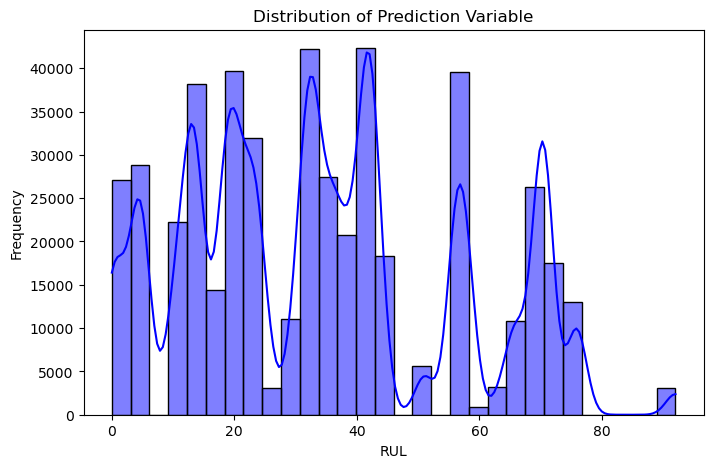

In [44]:
# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True, color='blue', edgecolor='black')

# Labels and title
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Variable')

# Show plot
plt.show()


In [92]:
import numpy as np
from scipy.stats import linregress

# Function to compute slope across time steps for each feature
def compute_slope(arr):
    time_steps = np.arange(arr.shape[0])  
    return np.array([linregress(time_steps, arr[:, i]).slope for i in range(arr.shape[1])])

# Prepare an empty array to store slopes for all samples
slopes = np.zeros((X.shape[0], X.shape[2]))  

# Loop over each sample and compute slopes
for i in range(X.shape[0]):
    slopes[i] = compute_slope(X[i])

print("Slope Shape:", slopes.shape) 


KeyboardInterrupt



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of slopes for the first feature as an example
sns.histplot(slopes[:, 0], bins=50, kde=True)  # Adjust the feature index as needed
plt.title('Distribution of Slopes for Feature 0')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Assuming 'target' is your target variable
correlations = np.corrcoef(slopes.T, target)
print("Correlations with target variable:", correlations[-1, :-1])  # Last row correlates with target